In [2]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn streamlit

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression


In [4]:
from google.colab import files

uploaded = files.upload()

Saving Global EV Charging Stations.zip to Global EV Charging Stations.zip


In [5]:
import zipfile
zip_path = "Global EV Charging Stations.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("ev_data")

In [6]:
import os
os.listdir("ev_data")

['charging_stations_2025_world.csv',
 'ev_models_2025.csv',
 'world_summary_2025.csv',
 'country_summary_2025.csv']

In [7]:
import pandas as pd

stations = pd.read_csv("ev_data/charging_stations_2025_world.csv")
models = pd.read_csv("ev_data/ev_models_2025.csv")
world_summary = pd.read_csv("ev_data/world_summary_2025.csv")
country_summary = pd.read_csv("ev_data/country_summary_2025.csv")

print("Charging Stations:")
print(stations.head(), "\n")

print("EV Models:")
print(models.head(), "\n")

print("World Summary:")
print(world_summary.head(), "\n")

print("Country Summary:")
print(country_summary.head())


Charging Stations:
       id                         name     city country_code state_province  \
0  307660             Av. de Tarragona  Andorra           AD            NaN   
1  301207        Parquing Costa Rodona   Encamp           AD            NaN   
2  301206                  Hotel Naudi      NaN           AD            NaN   
3  301205  Hotel Piolets Soldeu Centre      NaN           AD            NaN   
4  301204                 Hotel Serras      NaN           AD            NaN   

    latitude  longitude  ports  power_kw         power_class  is_fast_dc  
0  42.505254   1.528861     10     300.0  DC_ULTRA_(>=150kW)        True  
1  42.537213   1.727014     10      22.0   AC_HIGH_(22-49kW)       False  
2  42.576811   1.666061      1      11.0    AC_L2_(7.5-21kW)       False  
3  42.576466   1.667317      1      22.0   AC_HIGH_(22-49kW)       False  
4  42.579458   1.659215      3      11.0    AC_L2_(7.5-21kW)       False   

EV Models:
    make       model           market_regio

In [9]:
print("Stations Columns:", stations.columns.tolist(), "\n")
print("Models Columns:", models.columns.tolist(), "\n")
print("World Summary Columns:", world_summary.columns.tolist(), "\n")
print("Country Summary Columns:", country_summary.columns.tolist(), "\n")


Stations Columns: ['id', 'name', 'city', 'country_code', 'state_province', 'latitude', 'longitude', 'ports', 'power_kw', 'power_class', 'is_fast_dc'] 

Models Columns: ['make', 'model', 'market_regions', 'powertrain', 'first_year', 'body_style', 'origin_country'] 

World Summary Columns: ['country_code', 'country', 'count', 'max_power_kw_max'] 

Country Summary Columns: ['country_code', 'stations'] 



In [11]:
# Stations
stations = stations.dropna(subset=["latitude", "longitude", "country_code"])
stations.loc[:, "country_code"] = stations["country_code"].str.strip()

# Models
models = models.dropna(subset=["make", "model", "first_year"])
models.loc[:, "first_year"] = models["first_year"].astype(int)

# Save Cleaned Files
stations.to_csv("clean_ev_stations.csv", index=False)
models.to_csv("clean_ev_models.csv", index=False)
country_summary.to_csv("clean_country_summary.csv", index=False)
world_summary.to_csv("clean_world_summary.csv", index=False)

print("Data cleaned and saved")

Data cleaned and saved


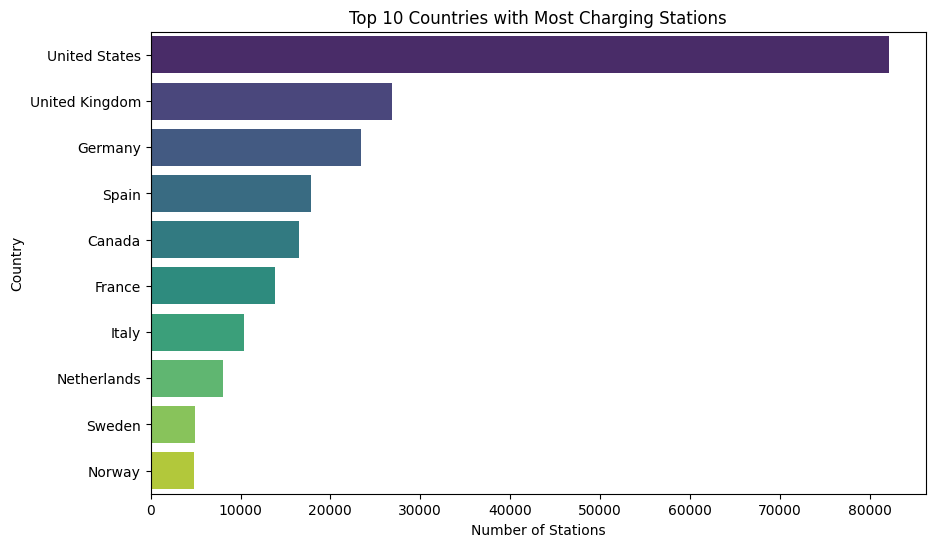

In [13]:
# Count stations by country_code
stations_count = stations.groupby("country_code").size().reset_index(name="station_count")

# Merge with world_summary to get country names
stations_count = stations_count.merge(
    world_summary[["country_code", "country"]],
    on="country_code",
    how="left"
)

# Top 10 countries
top10 = stations_count.sort_values("station_count", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10,
    x="station_count",
    y="country",
    hue="country",
    palette="viridis",
    dodge=False,
    legend=False
)
plt.title("Top 10 Countries with Most Charging Stations")
plt.xlabel("Number of Stations")
plt.ylabel("Country")
plt.show()

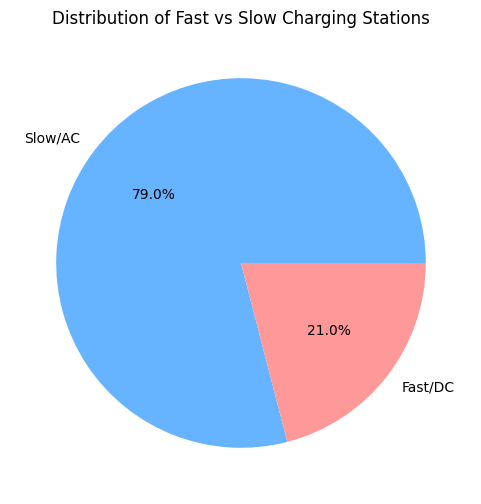

In [16]:
plt.figure(figsize=(6,6))
stations["is_fast_dc"].value_counts().rename({0: "Slow/AC", 1: "Fast/DC"}).plot.pie(
    autopct="%1.1f%%",
    colors=["#66b3ff", "#ff9999"]
)
plt.title("Distribution of Fast vs Slow Charging Stations")
plt.ylabel("")
plt.show()



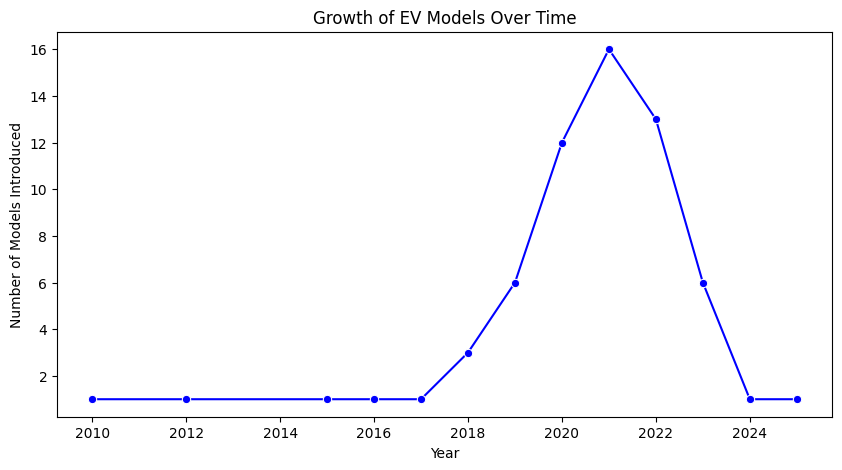

In [17]:
models_per_year = models.groupby("first_year").size().reset_index(name="count")

plt.figure(figsize=(10,5))
sns.lineplot(
    data=models_per_year,
    x="first_year",
    y="count",
    marker="o",
    color="blue"
)
plt.title("Growth of EV Models Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Models Introduced")
plt.show()


In [18]:
# Merge stations count with world summary
cluster_data = country_summary.merge(
    world_summary[["country_code", "max_power_kw_max"]],
    on="country_code",
    how="left"
)
cluster_data = cluster_data.dropna()

# Features for clustering
X = cluster_data[["stations", "max_power_kw_max"]]

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_data["cluster"] = kmeans.fit_predict(X)

# Scatter plot
fig = px.scatter(
    cluster_data,
    x="stations",
    y="max_power_kw_max",
    color="cluster",
    hover_name="country_code",
    title="Clustering of Countries by Charging Infrastructure",
    labels={"stations": "Number of Stations", "max_power_kw_max": "Max Power (kW)"}
)
fig.show()

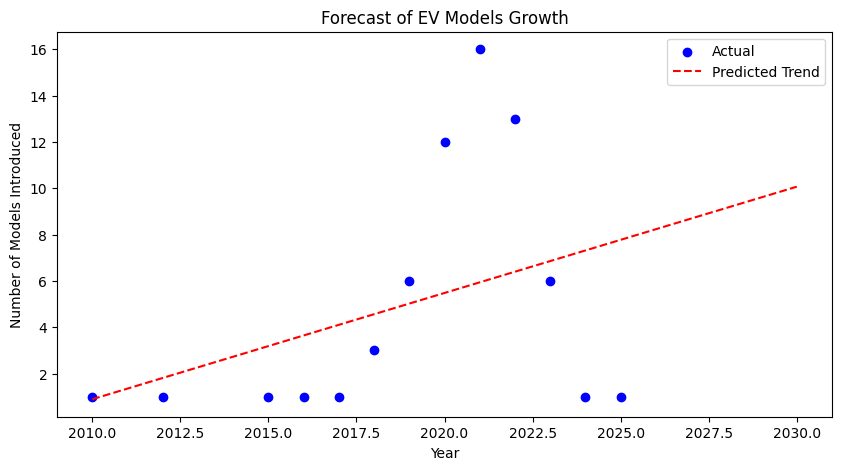

In [19]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare data
models_per_year = models.groupby("first_year").size().reset_index(name="count")
X = models_per_year[["first_year"]]
y = models_per_year["count"]

# Train Linear Regression
lr = LinearRegression()
lr.fit(X, y)

# Predict future years (up to 2030)
future_years = pd.DataFrame({"first_year": np.arange(models_per_year["first_year"].min(), 2031)})
future_preds = lr.predict(future_years)

# Plot
plt.figure(figsize=(10,5))
plt.scatter(X, y, color="blue", label="Actual")
plt.plot(future_years, future_preds, color="red", linestyle="--", label="Predicted Trend")
plt.title("Forecast of EV Models Growth")
plt.xlabel("Year")
plt.ylabel("Number of Models Introduced")
plt.legend()
plt.show()


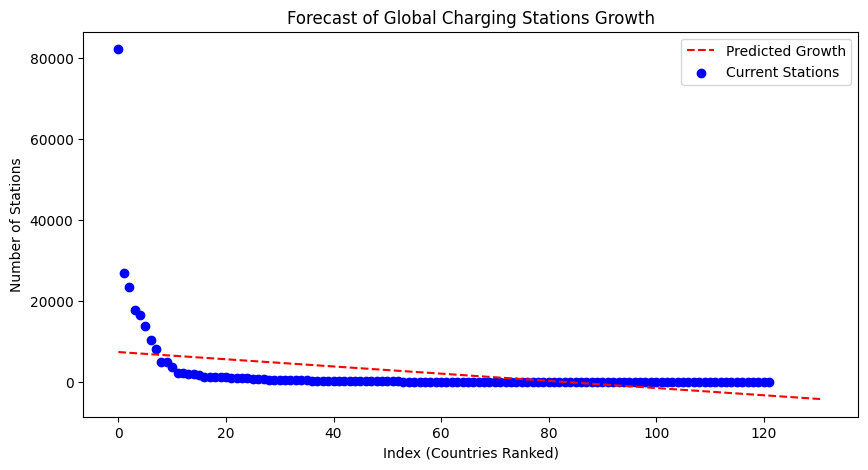

In [20]:
# Aggregate stations by country_code first, then merge with year if available
# Since we don't have yearly data in stations, we'll simulate growth using count trend

stations_per_country = country_summary.sort_values("stations", ascending=False)

# Simple assumption: growth is proportional to current station count
X = np.arange(len(stations_per_country)).reshape(-1,1)
y = stations_per_country["stations"].values

lr2 = LinearRegression()
lr2.fit(X, y)

# Forecast next 10 "steps" (countries ranked by future growth potential)
future_X = np.arange(len(stations_per_country)+10).reshape(-1,1)
future_y = lr2.predict(future_X)

# Plot
plt.figure(figsize=(10,5))
plt.plot(future_X, future_y, color="red", linestyle="--", label="Predicted Growth")
plt.scatter(X, y, color="blue", label="Current Stations")
plt.title("Forecast of Global Charging Stations Growth")
plt.xlabel("Index (Countries Ranked)")
plt.ylabel("Number of Stations")
plt.legend()
plt.show()


In [21]:
sampled_stations = stations.sample(n=min(5000, len(stations)), random_state=42)

fig = px.scatter_geo(
    sampled_stations,
    lat="latitude",
    lon="longitude",
    color="is_fast_dc",
    hover_name="name",
    hover_data={"city": True, "country_code": True, "power_kw": True},
    title="Global EV Charging Stations (sampled)",
    projection="natural earth",
    color_continuous_scale="Viridis"
)

fig.show()


In [22]:
stations_count = stations.groupby("country_code").size().reset_index(name="station_count")

fig = px.choropleth(
    stations_count,
    locations="country_code",
    color="station_count",
    hover_name="country_code",
    color_continuous_scale="Blues",
    title="EV Charging Stations per Country"
)

fig.show()